In [45]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import pickle
from scipy.spatial.distance import pdist, squareform
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

from collections import defaultdict

# Setup

In [46]:
df = pd.read_csv('rmse_ts.csv', index_col='id')

In [47]:
df.head()

0         1         2         3         4         5         6  \
id                                                                         
2   0.005965  0.030530  0.038409  0.052510  0.081335  0.096664  0.092021   
3   0.009710  0.088201  0.120011  0.128533  0.150989  0.169258  0.205793   
5   0.004292  0.036312  0.051975  0.046670  0.203390  0.283229  0.314644   
10  0.110271  0.142744  0.156790  0.131847  0.125279  0.129176  0.128395   
20  0.245351  0.239747  0.211342  0.181047  0.184478  0.177384  0.142504   

           7         8         9  ...      1282      1283      1284      1285  \
id                                ...                                           
2   0.083451  0.083296  0.086539  ...  0.167174  0.126127  0.111858  0.095006   
3   0.261233  0.279276  0.259404  ...  0.126499  0.103162  0.147984  0.207548   
5   0.322023  0.293859  0.251127  ...  0.318426  0.312173  0.305558  0.281919   
10  0.171358  0.298087  0.304533  ...  0.296138  0.217364  0.184314  0.176318   
20  0.206317  0.242042  0.226818  ...  0.333991  0.285059  0.176683  0.181024   

        1286      1287      1288      1289      1290      1291  
id                                                              
2   0.099327  0.097803  0.107587  0.152822  0.177150  0.000000  
3   0.256682  0.254089  0.194205  0.146202  0.119663  0.121850  
5   0.234308  0.178978  0.163058  0.143980  0.120217  0.107188  
10  0.161866  0.158079  0.158619  0.148111  0.146005  0.000000  
20  0.188473  0.168699  0.164692  0.181571  0.183699  0.000000  

[5 rows x 1292 columns]

In [5]:
#Amplitude scaling df
scaler = TimeSeriesScalerMeanVariance(mu=0, std=1.)
df = df.T.apply(lambda x: scaler.fit_transform(x.values.reshape(1, -1)).flatten()).T

In [6]:
#Rock (4772, 35541, 36835)
#Classical (43100, 25928, 82070)
ts_list1 = []
ts_list2 = []

ts_list1.append(np.squeeze(df[df.index == 4772].values))
ts_list1.append(np.squeeze(df[df.index == 35541].values))
ts_list1.append(np.squeeze(df[df.index == 36835].values))

ts_list2.append(np.squeeze(df[df.index == 43100].values))
ts_list2.append(np.squeeze(df[df.index == 25928].values))
ts_list2.append(np.squeeze(df[df.index == 82070].values))

# Motif

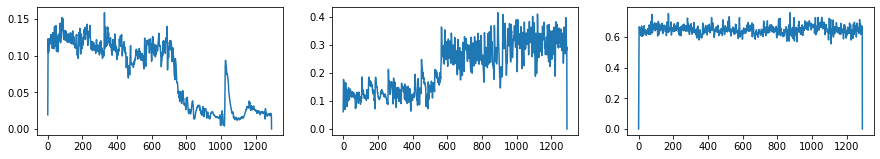

In [5]:
plt.figure(figsize=(15, 8)) 
i=1

for ts in ts_list1:
    plt.subplot(3,3,i)
    plt.plot(ts)
    i=i+1
    
plt.show()

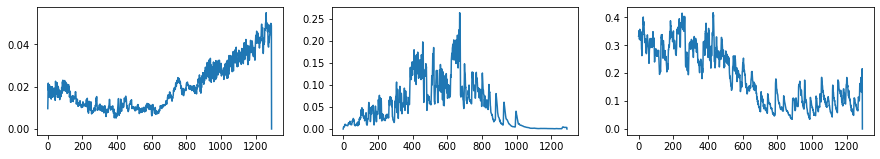

In [6]:
plt.figure(figsize=(15, 8)) 
i=1

for ts in ts_list2:
    plt.subplot(3,3,i)
    #plt.ylim([-3,3])
    plt.plot(ts)
    i=i+1
    
plt.show()

In [7]:
w = 8 #Noise smoothing

for i in range(len(ts_list1)):
    ts = pd.Series(ts_list1[i].reshape(1, -1).squeeze())
    ts_list1[i] = ((ts - ts.mean())/ts.std()).rolling(window=w, min_periods=1).mean().to_numpy()

In [8]:
w = 8 #Noise smoothing

for i in range(len(ts_list2)):
    ts = pd.Series(ts_list2[i].reshape(1, -1).squeeze())
    ts_list2[i] = ((ts - ts.mean())/ts.std()).rolling(window=w, min_periods=1).mean().to_numpy()

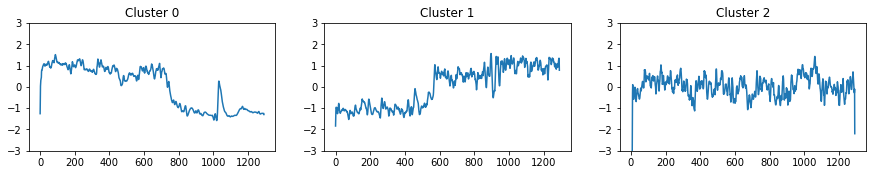

In [9]:
plt.figure(figsize=(15, 8)) 
i=1

for ts in ts_list1:
    plt.subplot(3,3,i)
    plt.title('Cluster '+str(i-1))
    plt.ylim([-3,3])
    plt.plot(ts)
    i=i+1
    
#plt.savefig('medoid_rock.pdf', bbox_inches='tight')
plt.show()

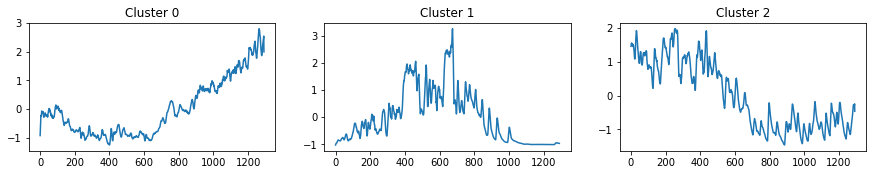

In [10]:
plt.figure(figsize=(15, 8)) 
i=1

for ts in ts_list2:
    plt.subplot(3,3,i)
    plt.title('Cluster '+str(i-1))
    plt.plot(ts)
    i=i+1
    
#plt.savefig('medoid_classical.pdf', bbox_inches='tight')
plt.show()

## Matrix profile

In [11]:
from matrixprofile import *

In [12]:
w1 = [44*1, 44*1, 44*1]
w2 = [44*1, 44*1, 44*1]

mp_list1 = []
mp_list2 = []

for i in range(len(ts_list1)):
    mp_list1.append((matrixProfile.stomp(ts_list1[i], w1[i])))
    
for i in range(len(ts_list2)):
    mp_list2.append((matrixProfile.stomp(ts_list2[i], w2[i])))

Parameters
- max_motifs: stop finding new motifs once we have max_motifs
- radius: For each motif found, find neighbors that are within radius*motif_mp of the first.
- n_neighbors: number of neighbors from the first to find. If it is None, find all.
- ex_zone: minimum distance between indices for after each subsequence is identified. Defaults to m/2 where m is the subsequence length. If ex_zone = 0, only the found index is exclude, if ex_zone = 1 then if idx is found as a motif idx-1, idx, idx+1 are excluded.

Returns
The function returns a tuple (top_motifs, distances) which are lists of the same length.

- top_motifs: This is a list of the indices found for each motif. The first index is the nth motif followed by all nearest neighbors found sorted by distances.
- distances: Minimum Matrix profile value for each motif set.

In [13]:
motif_list1 = []
motif_list2 = []

for i in range(len(ts_list1)):
    motif_list1.append(motifs.motifs(ts_list1[i], (mp_list1[i][0], mp_list1[i][1]), max_motifs=5, radius=2))
    
for i in range(len(ts_list2)):
    motif_list2.append(motifs.motifs(ts_list2[i], (mp_list2[i][0], mp_list2[i][1]), max_motifs=5, radius=3))

In [14]:
motif_list1[0][0], motif_list1[0][1], motif_list2[0][0], motif_list2[0][1]

([[737, 949, 1037], [434, 1178], [82, 238, 867], [335, 517, 897]],
 [0.6817362573675771,
  1.0295126194431858,
  1.5411416066483723,
  1.5489563950478693],
 [[69, 419, 637, 678, 728, 782, 848, 896, 1034, 1187],
  [112, 153, 362, 475, 578, 753, 805, 985],
  [15, 319, 538, 951, 1106, 1223],
  [244, 614, 701, 871, 1083, 1141],
  [46, 442, 514]],
 [1.2077124044124448,
  1.2919436174312313,
  1.582804353443429,
  1.6844580983078647,
  1.8489892503040308])

In [15]:
colors1 = []
colors2 = []

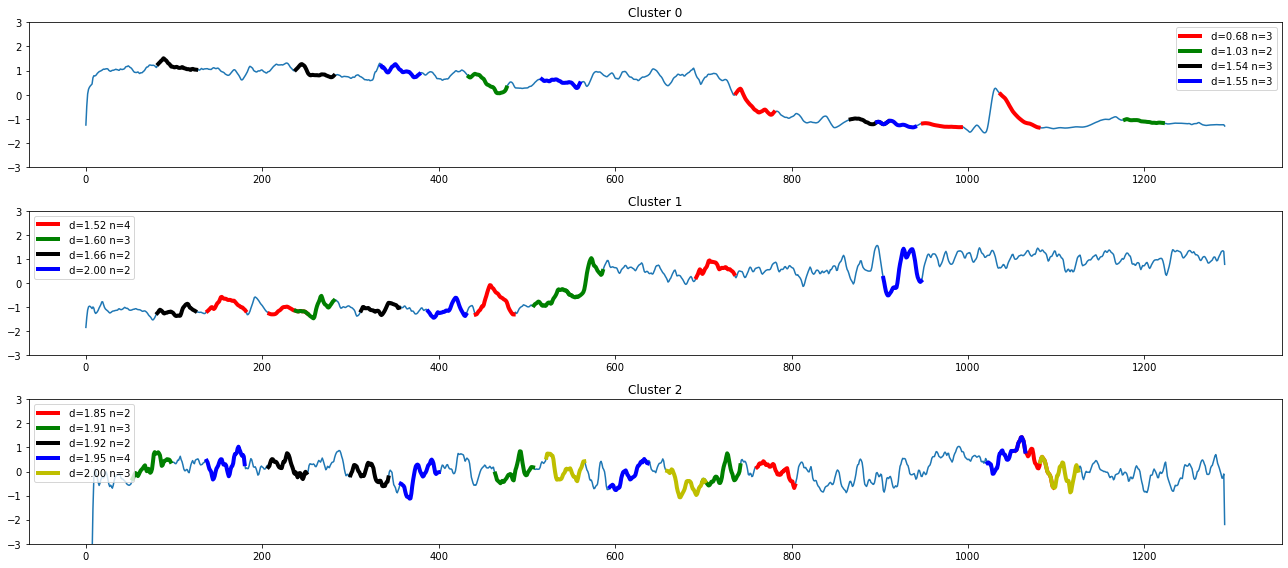

In [16]:
plt.figure(figsize=(18, 8)) 

for i in range(len(ts_list1)):
    ts1 = ts_list1[i]
    mo1 = motif_list1[i][0]
    mod1 = motif_list1[i][1]
    
    plt.subplot(3,1,i+1)
    plt.plot(ts1)
    plt.ylim([-3,3])
    plt.title('Cluster '+ str(i))
    colors1_ = ['r', 'g', 'k', 'b', 'y', 'lime', 'm', 'darkorange', 'tab:brown'][:len(mo1)]
    colors1.append(colors1_)
    for m, d, c in zip(mo1, mod1, colors1_):
        t=0
        for i_ in m:
            m_shape = ts1[i_:i_+w1[i]]
            if(t==0):
                plt.plot(range(i_,i_+w1[i]), m_shape, color=c, lw=4, label=" d=" + str("%.2f" % round(d, 2)) + " n=" +str(len(m)))
            else:
                plt.plot(range(i_,i_+w1[i]), m_shape, color=c, lw=4)
            t=t+1
            
        plt.legend()

plt.tight_layout()   
plt.savefig('motif_rock.pdf', bbox_inches='tight')

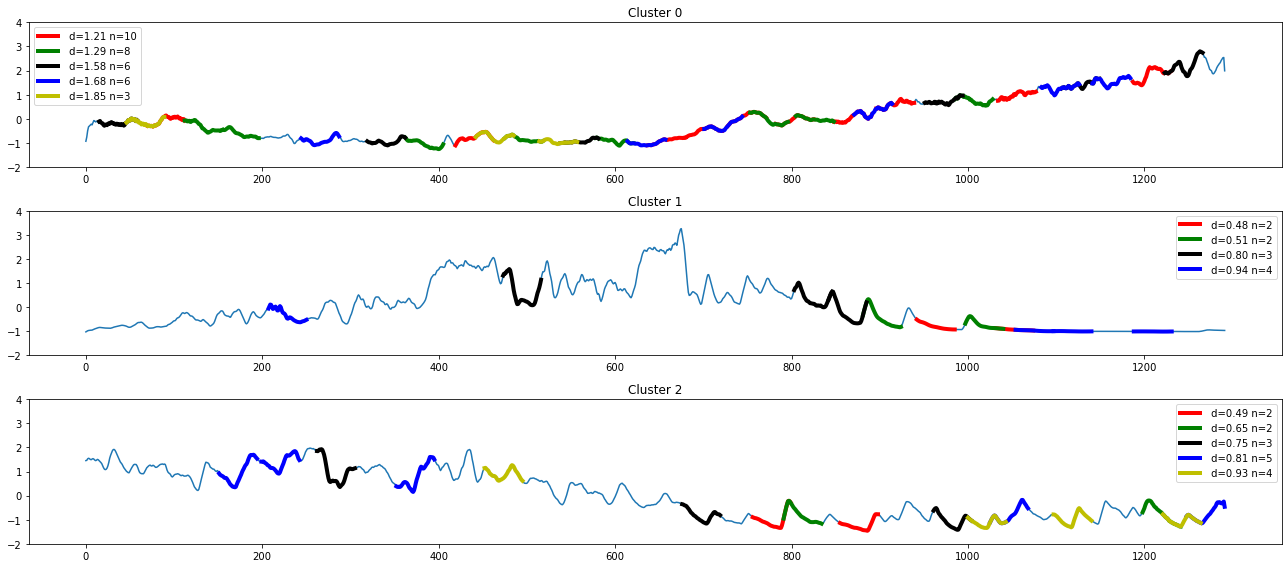

In [17]:
plt.figure(figsize=(18, 8)) 

for i in range(len(ts_list2)):
    ts2 = ts_list2[i]
    mo2 = motif_list2[i][0]
    mod2 = motif_list2[i][1]
    
    plt.subplot(3,1,i+1)
    plt.plot(ts2)
    plt.ylim([-2,4])
    plt.title('Cluster '+ str(i))
    colors2_ = ['r', 'g', 'k', 'b', 'y', 'lime', 'm', 'darkorange', 'tab:brown'][:len(mo2)]
    colors2.append(colors2_)
    for m, d, c in zip(mo2, mod2, colors2_):
        t=0
        for i_ in m:
            m_shape = ts2[i_:i_+w2[i]]
            if(t==0):
                plt.plot(range(i_,i_+w2[i]), m_shape, color=c, lw=4, label= " d=" + str("%.2f" % round(d, 2))+ " n=" +str(len(m)))
            else:
                plt.plot(range(i_,i_+w2[i]), m_shape, color=c, lw=4)
            t=t+1

        plt.legend()
        
plt.tight_layout()   
plt.savefig('motif_classical.pdf', bbox_inches='tight')

In [18]:
import warnings
warnings.filterwarnings("ignore")

Cluster 0


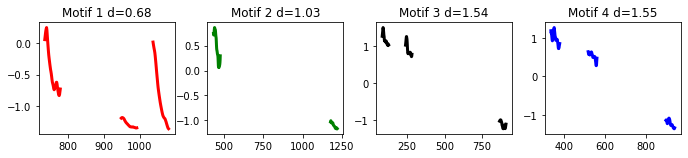

Cluster 1


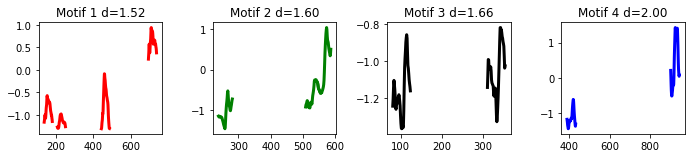

Cluster 2


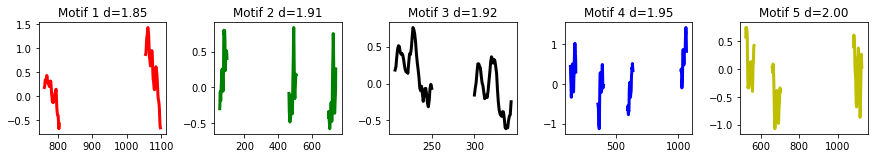

In [19]:
for i in range(len(ts_list1)):
    n=0
    plt.figure(figsize=(12, 4))
    ts1 = ts_list1[i]
    mo1 = motif_list1[i][0]
    mod1 = motif_list1[i][1]
    
    print("Cluster " + str(i))
    
    for m, d, c in zip(mo1, mod1, colors1[i]):
        n=n+1
        plt.subplot(2,5,n)
        plt.title("Motif " + str(n) + " d=" + str("%.2f" % round(d, 2)))
        for i_ in m:
            m_shape = ts1[i_:i_+w1[i]]
            plt.plot(range(i_,i_+w1[i]), m_shape, color=c, lw=3)
            
    plt.tight_layout()
    plt.show()

Cluster 0


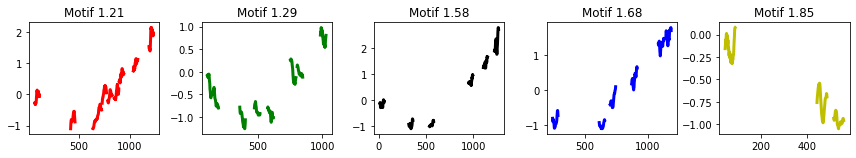

Cluster 1


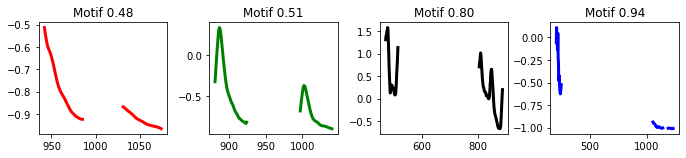

Cluster 2


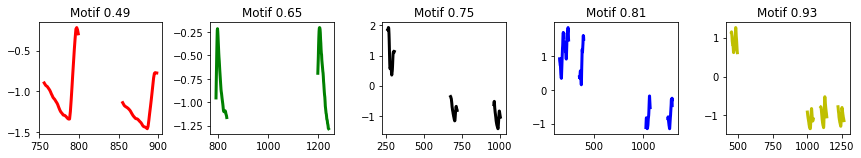

In [20]:
for i in range(len(ts_list2)):
    n=0
    plt.figure(figsize=(12, 4))
    ts2 = ts_list2[i]
    mo2 = motif_list2[i][0]
    mod2 = motif_list2[i][1]
    
    print("Cluster " + str(i))
    
    for m, d, c in zip(mo2, mod2, colors2[i]):
        n=n+1
        plt.subplot(2,5,n)
        plt.title("Motif " + str("%.2f" % round(d, 2)))
        for i_ in m:
            m_shape = ts2[i_:i_+w2[i]]
            plt.plot(range(i_,i_+w2[i]), m_shape, color=c, lw=3)

    plt.tight_layout()
    plt.show()

In [21]:
import librosa
import IPython.display as ipd

In [22]:
motif_list1[0][0]

[[737, 949, 1037], [434, 1178], [82, 238, 867], [335, 517, 897]]

In [23]:
y, sr = librosa.load("motifs/004772.mp3", sr=22050, mono=True)
for j in motif_list1[0][0]:
    print("Motif "+ str(j))
    for k in range(len(j)):
        start = j[k]*512
        stop = (j[k]+w1[0])*512
        ipd.display(ipd.Audio(y[start:stop], rate=sr))

Motif [737, 949, 1037]


Motif [434, 1178]


Motif [82, 238, 867]


Motif [335, 517, 897]


In [24]:
y, sr = librosa.load("motifs/035541.mp3", sr=22050, mono=True)
for j in motif_list1[1][0]:
    print("Motif "+ str(j))
    for k in range(len(j)):
        start = j[k]*512
        stop = (j[k]+w1[1])*512
        ipd.display(ipd.Audio(y[start:stop], rate=sr))

Motif [138, 208, 442, 692]


Motif [238, 508, 543]


Motif [81, 312]


Motif [388, 904]


In [25]:
y, sr = librosa.load("motifs/036835.mp3", sr=22050, mono=True)
for j in motif_list1[2][0]:
    print("Motif "+ str(j))
    for k in range(len(j)):
        start = j[k]*512
        stop = (j[k]+w1[2])*512
        ipd.display(ipd.Audio(y[start:stop], rate=sr))

Motif [761, 1054]


Motif [53, 464, 699]


Motif [207, 300]


Motif [137, 357, 594, 1022]


Motif [522, 659, 1082]


In [26]:
y, sr = librosa.load("motifs/043100.mp3", sr=22050, mono=True)
for j in motif_list2[0][0]:
    print("Motif "+ str(j))
    for k in range(len(j)):
        start = j[k]*512
        stop = (j[k]+w2[0])*512
        ipd.display(ipd.Audio(y[int(start):int(stop)], rate=sr))

Motif [69, 419, 637, 678, 728, 782, 848, 896, 1034, 1187]


Motif [112, 153, 362, 475, 578, 753, 805, 985]


Motif [15, 319, 538, 951, 1106, 1223]


Motif [244, 614, 701, 871, 1083, 1141]


Motif [46, 442, 514]


(228218.88, 373749.76)

In [27]:
y, sr = librosa.load("motifs/025928.mp3", sr=22050, mono=True)
for j in motif_list2[1][0]:
    print("Motif "+ str(j))
    for k in range(len(j)):
        start = int(np.ceil(j[k]*512))
        stop = int(np.ceil((j[k]+w2[1])*512))
        ipd.display(ipd.Audio(y[start:stop], rate=sr))

Motif [942, 1031]


Motif [881, 997]


Motif [473, 803, 842]


Motif [207, 1054, 1097, 1188]


In [28]:
y, sr = librosa.load("motifs/082070.mp3", sr=22050, mono=True)
for j in motif_list2[2][0]:
    print("Motif "+ str(j))
    for k in range(len(j)):
        start = int(np.ceil(j[k]*512))
        stop = int(np.ceil((j[k]+w2[2])*512))
        ipd.display(ipd.Audio(y[start:stop], rate=sr))

Motif [756, 855]


Motif [791, 1198]


Motif [262, 676, 961]


Motif [151, 199, 352, 1025, 1248]


Motif [452, 1000, 1097, 1221]


## Anomaly Discovery

In [123]:
from matrixprofile.discords import discords

Parameters  
- mp: matrix profile numpy array
- k: the number of discords to discover
- ex_zone: the number of samples to exclude and set to Inf on either side of a found discord    

Returns 
 - a list of indexes represent the discord starting locations. MaxInt indicates there were no more discords that could be found due to too many exclusions or profile being too small. Discord start indices are sorted by highest matrix profile value.

In [196]:
w1 = [44, 44, 44]
w2 = [10, 10, 10]

mp_list1 = []
mp_list2 = []

for i in range(len(ts_list1)):
    mp_list1.append((matrixProfile.stomp(ts_list1[i], w1[i])))
    
for i in range(len(ts_list2)):
    mp_list2.append((matrixProfile.stomp(ts_list2[i], w2[i])))

In [197]:
mp_list1

[(array([3.40704317, 2.89541103, 2.44661933, ..., 2.53950359, 2.58607214,
         2.74202159]),
  array([1140.,  498.,  498., ...,  231.,  232.,  233.])),
 (array([6.04068448, 4.91203927, 4.39094837, ..., 2.69476278, 2.59962464,
         2.93713583]),
  array([ 918., 1063.,  632., ...,  186.,  187.,  188.])),
 (array([2.96688714, 3.09772334, 3.13993569, ..., 5.52779229, 5.48641252,
         5.22052779]),
  array([ 367.,  367.,  367., ...,  458., 1190., 1159.]))]

In [198]:
anoms_list1 = []
anoms_list2 = []

for i in range(len(ts_list1)):
    anoms_list1.append(discords(mp_list1[i][0], ex_zone=3, k=5))
    
for i in range(len(ts_list2)):
    anoms_list2.append(discords(mp_list2[i][0], ex_zone=3, k=4))

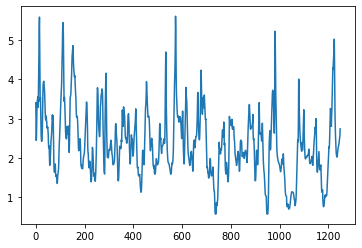

In [202]:
plt.plot(mp_list1[0][0])

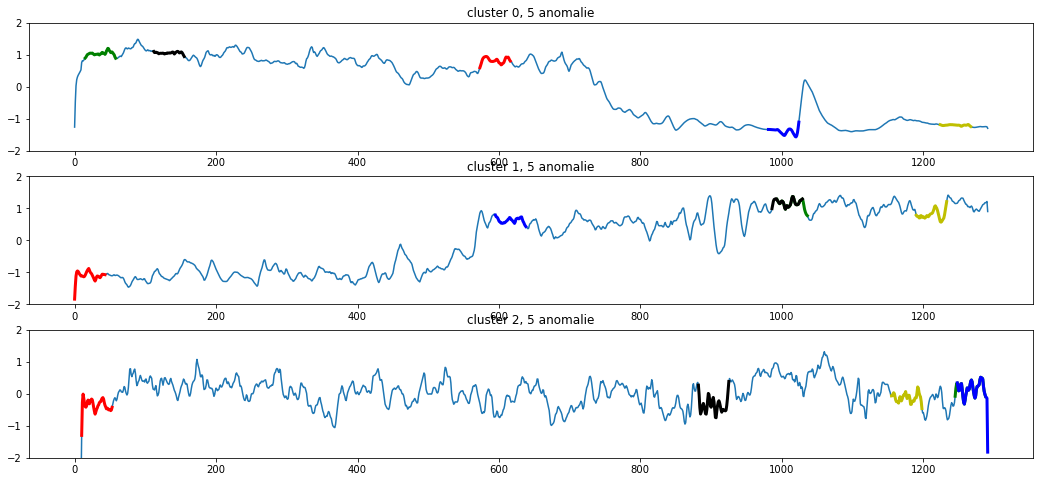

In [185]:
plt.figure(figsize=(18, 8))

for i in range(len(anoms_list1)):
    ts1 = ts_list1[i]
    anoms = anoms_list1[i]
    
    plt.subplot(3,1,i+1)
    plt.plot(ts1)
    plt.ylim([-2,2])
    plt.title('cluster '+ str(i) + ', ' + str(len(anoms)) + ' anomalie')
    colors1 = ['r', 'g', 'k', 'b', 'y', 'lime', 'm', 'darkorange', 'tab:brown'][:len(anoms)]
    
    for a, c in zip(anoms, colors1):
        a_shape = ts1[a:a+w1[i]]
        plt.plot(range(a, a+w1[i]), a_shape, color=c, lw=3)

plt.show()

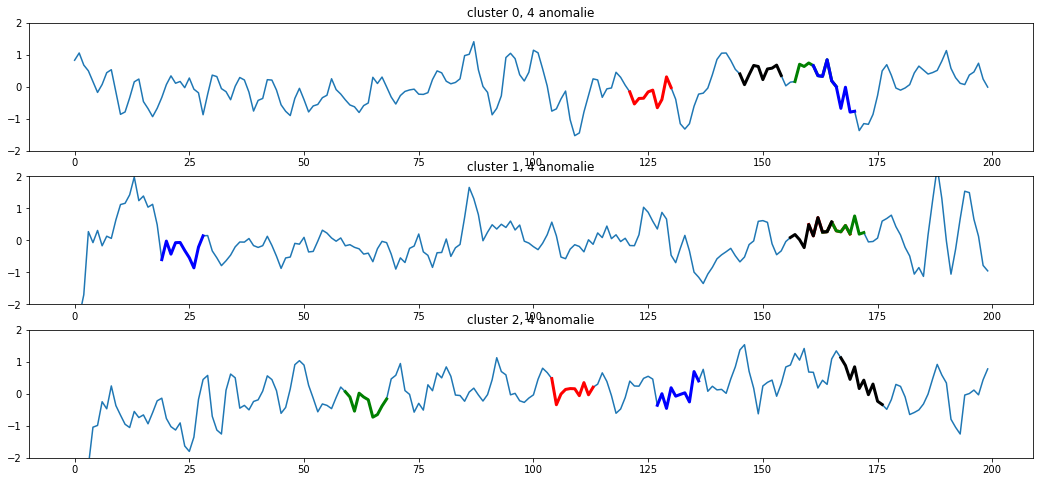

In [186]:
plt.figure(figsize=(18, 8))

for i in range(len(anoms_list2)):
    ts2 = ts_list2[i]
    anoms = anoms_list2[i]
    
    plt.subplot(3,1,i+1)
    plt.plot(ts2)
    plt.ylim([-2,2])
    plt.title('cluster '+ str(i) + ', ' + str(len(anoms)) + ' anomalie')
    colors2 = ['r', 'g', 'k', 'b', 'y', 'lime', 'm', 'darkorange', 'tab:brown'][:len(anoms)]
    
    for a, c in zip(anoms, colors2):
        a_shape = ts2[a:a+w2[i]]
        plt.plot(range(a, a+w2[i]), a_shape, color=c, lw=3)

plt.show()

In [51]:
import numpy
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

from tslearn.matrix_profile import MatrixProfile

C:\Users\Francesco\Anaconda3\lib\site-packages\tslearn\utils\utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


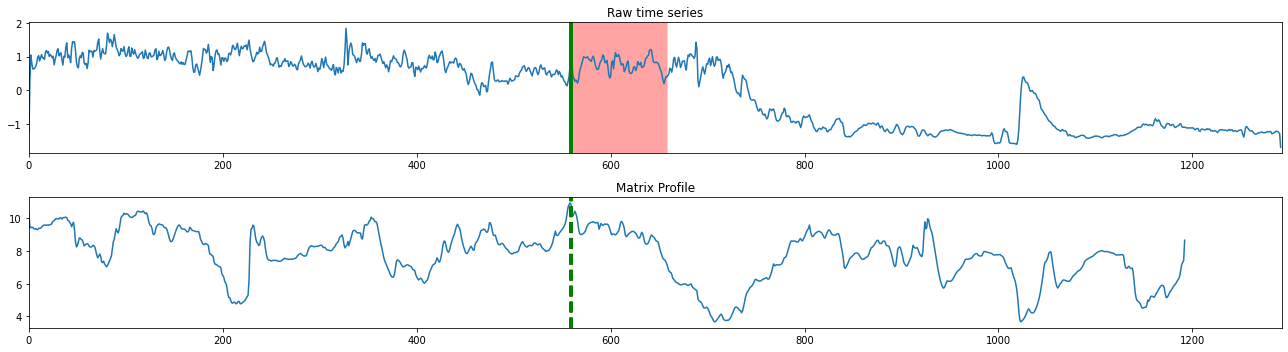

In [54]:
mp = MatrixProfile(subsequence_length=100, scale=True)

ts = ts_list1[0]
mp_series = mp.fit_transform([ts])[0]

t_star = mp_series.ravel().argsort()[-4:][::-1]

plt.figure(figsize=(18, 5))
ax = plt.subplot(2, 1, 1)  # First, raw time series
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
plt.plot(ts.ravel())
plt.xlim([0, ts.shape[0]])
#for i in anoms_list1[0]:
plt.axvline(x=t_star[0],  c="red", linewidth=3)
plt.fill_between(x=[t_star[0], t_star[0]+mp.subsequence_length], y1=0., y2=1., facecolor="r", alpha=.2, transform=trans)
plt.axvline(x=t_star[1],  c="green", linewidth=3)
plt.fill_between(x=[t_star[1], t_star[1]+mp.subsequence_length], y1=0., y2=1., facecolor="r", alpha=.2, transform=trans)
plt.title("Raw time series")

plt.subplot(2, 1, 2)  # Second, Matrix Profile
plt.plot(mp_series.ravel())
#for i in anoms_list1[0]:
plt.axvline(x=t_star[0],  c="red", linewidth=3, linestyle="dashed")
plt.axvline(x=t_star[1],  c="green", linewidth=3, linestyle="dashed")
plt.xlim([0, ts.shape[0]])
plt.title("Matrix Profile")

plt.tight_layout()
plt.show()

In [114]:
np.sort(mp_series.ravel())

array([ 2.42327878,  2.42327878,  2.4266033 , ...,  9.96636016,
       10.04715729, 10.31774206])

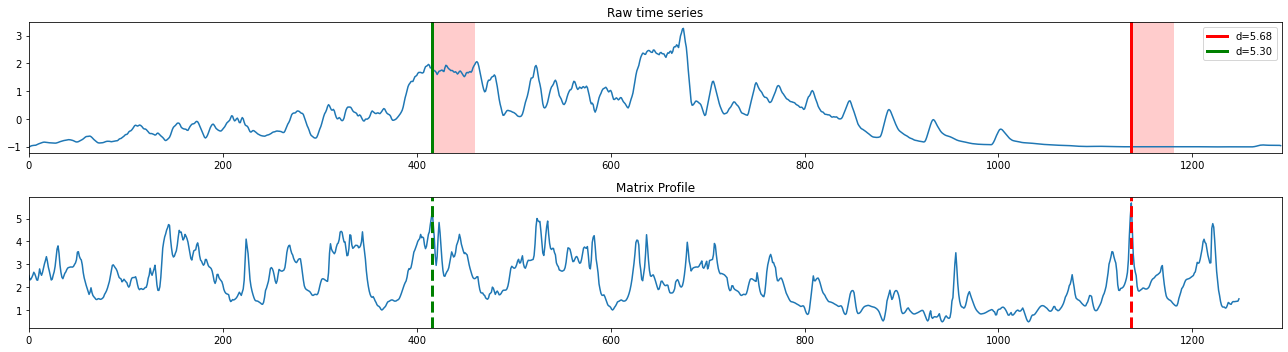

In [102]:
mp = MatrixProfile(subsequence_length=44, scale=True)

ts = ts_list2[1]
mp_series = mp.fit_transform([ts])[0]

t_star = mp_series.ravel().argsort()[-4:][::-1]
#t_star = numpy.argmax(mp_series.ravel())

plt.figure(figsize=(18, 5))
ax = plt.subplot(2, 1, 1)  # First, raw time series
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
plt.plot(ts.ravel())
plt.xlim([0, ts.shape[0]])
#for i in anoms_list1[0]:
plt.axvline(x=t_star[0],  c="red", linewidth=3, label="d=5.68")
plt.fill_between(x=[t_star[0], t_star[0]+mp.subsequence_length], y1=0., y2=1., facecolor="r", alpha=.2, transform=trans)
plt.axvline(x=t_star[1],  c="green", linewidth=3, label="d=5.30")
plt.fill_between(x=[t_star[1], t_star[1]+mp.subsequence_length], y1=0., y2=1., facecolor="r", alpha=.2, transform=trans)
plt.title("Raw time series")
plt.legend()

plt.subplot(2, 1, 2)  # Second, Matrix Profile
plt.plot(mp_series.ravel())
#for i in anoms_list1[0]:
plt.axvline(x=t_star[0],  c="red", linewidth=3, linestyle="dashed")
plt.axvline(x=t_star[1],  c="green", linewidth=3, linestyle="dashed")
plt.xlim([0, ts.shape[0]])
plt.title("Matrix Profile")

plt.tight_layout()
plt.show()

In [99]:
np.sort(mp_series.ravel())

array([0.47570651, 0.47570651, 0.5081326 , ..., 5.10849338, 5.2959169 ,
       5.68371224])

# MPF

https://matrixprofile.docs.matrixprofile.org/Quickstart.html

In [57]:
import matrixprofile as mp

from matplotlib import pyplot as plt
%matplotlib inline

In [58]:
ts = ts_list1[0]

C:\Users\Francesco\Anaconda3\lib\site-packages\matrixprofile\visualize.py:433: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\Francesco\Anaconda3\lib\site-packages\matrixprofile\visualize.py:433: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\Francesco\Anaconda3\lib\site-packages\matrixprofile\visualize.py:433: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


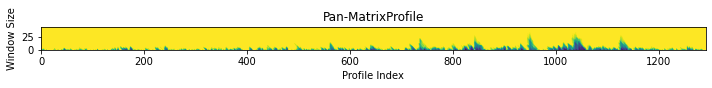

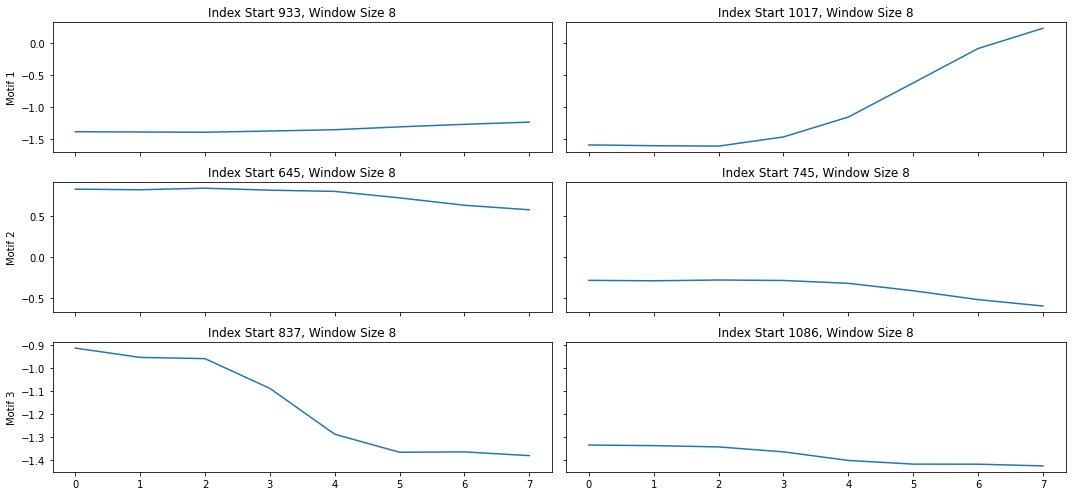

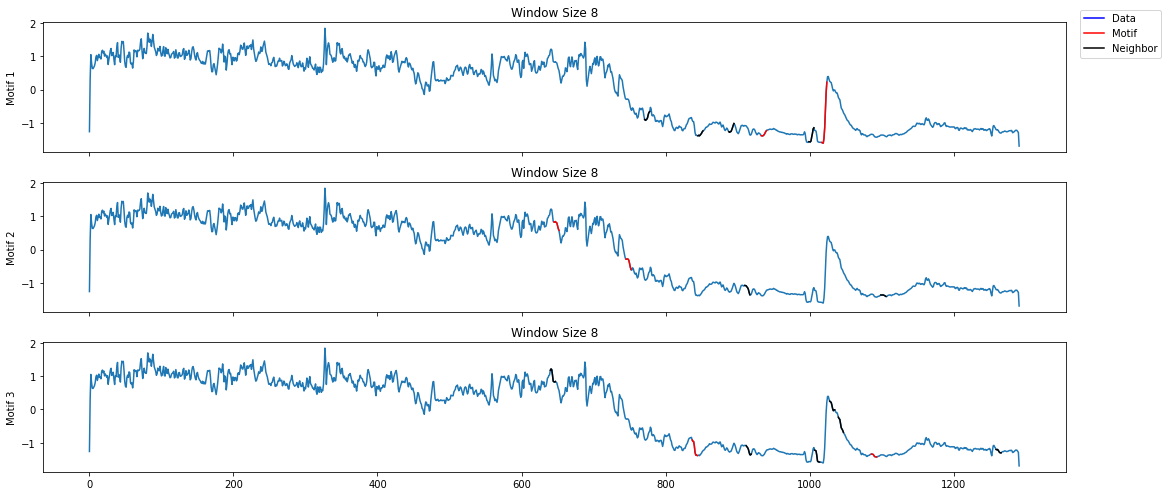

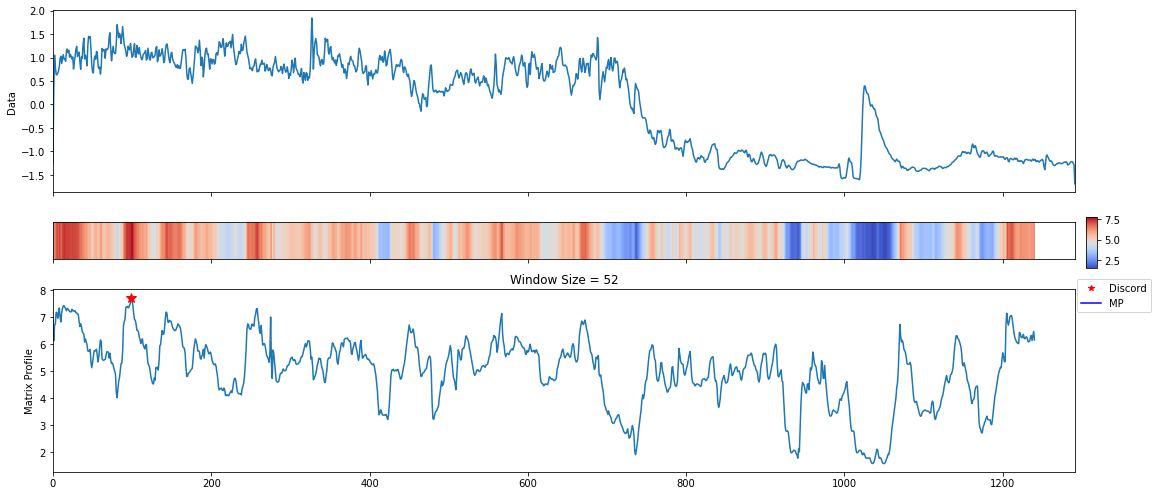

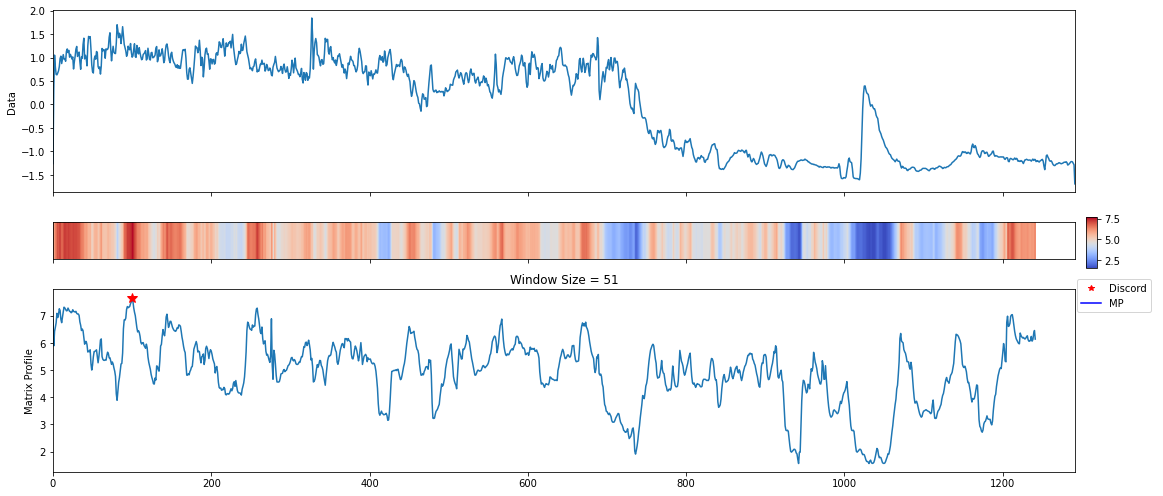

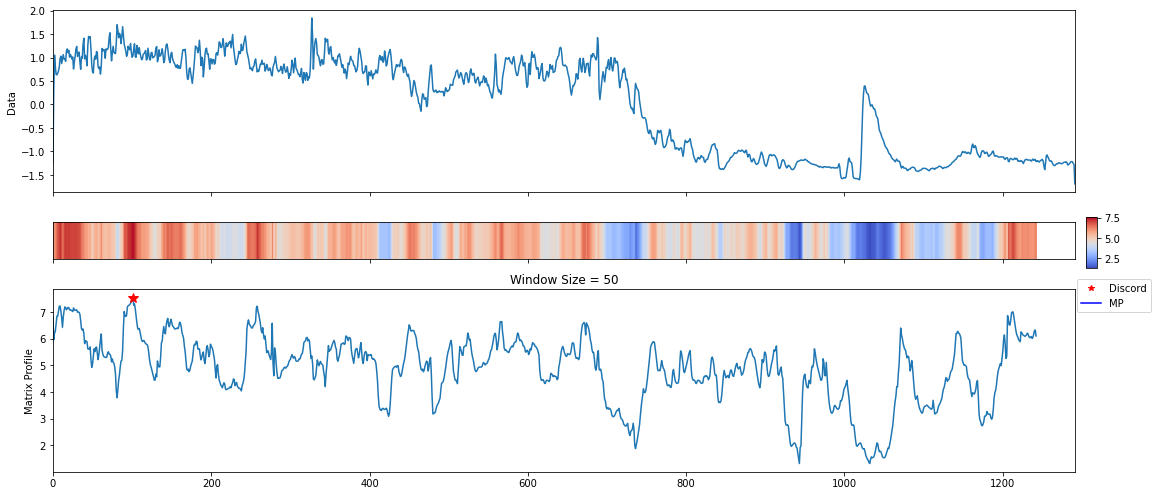

In [59]:
profile, figures = mp.analyze(ts, n_jobs=-1)

C:\Users\Francesco\Anaconda3\lib\site-packages\matrixprofile\visualize.py:375: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


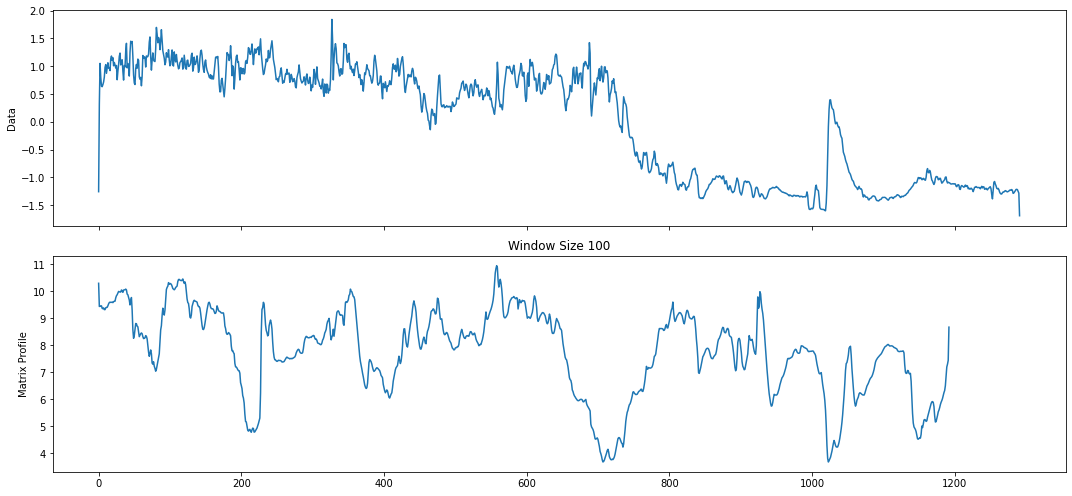

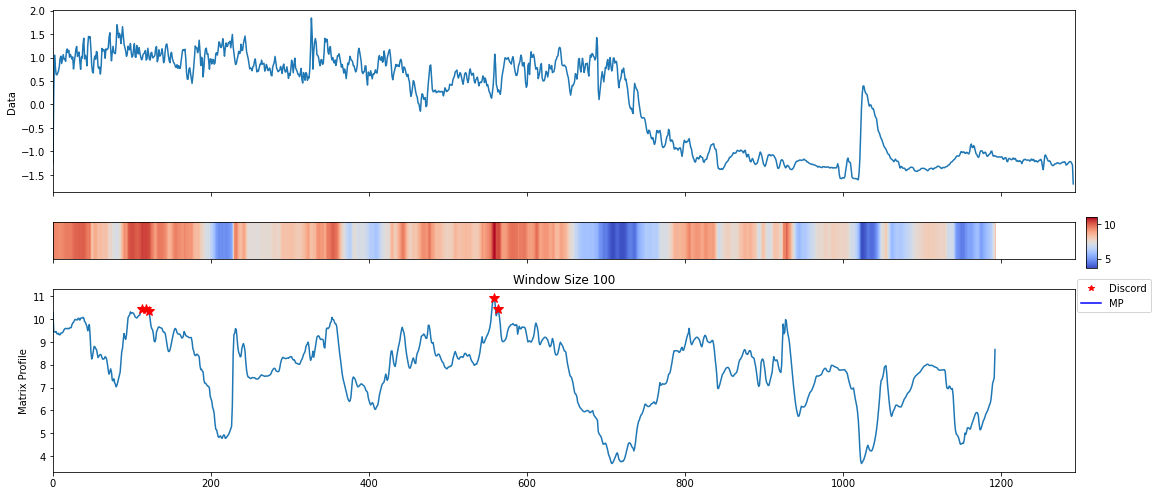

In [50]:
ts = ts_list1[0]
profile = mp.compute(ts, 100)
anoms = mp.discover.discords(profile, k=5, exclusion_zone=3)
figures = mp.visualize(anoms)

C:\Users\Francesco\Anaconda3\lib\site-packages\matrixprofile\visualize.py:375: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


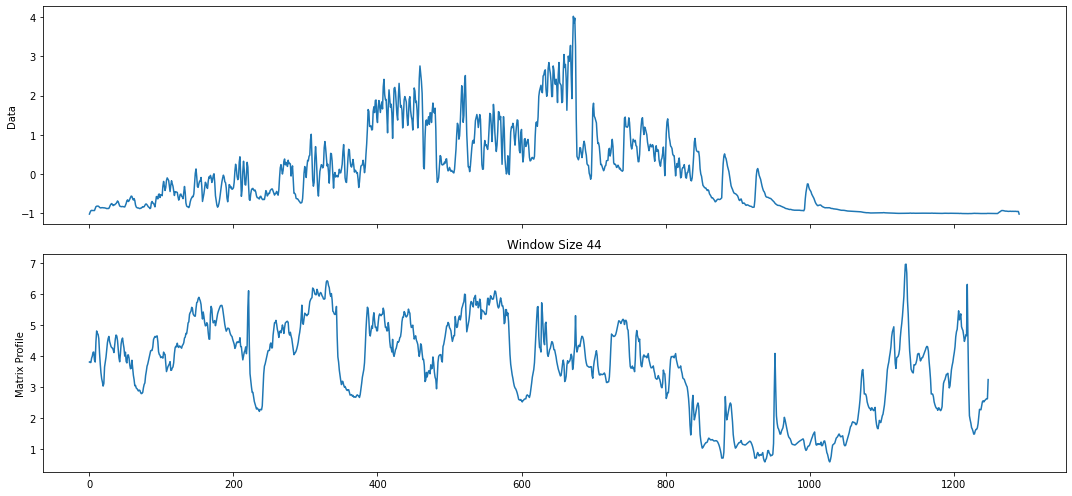

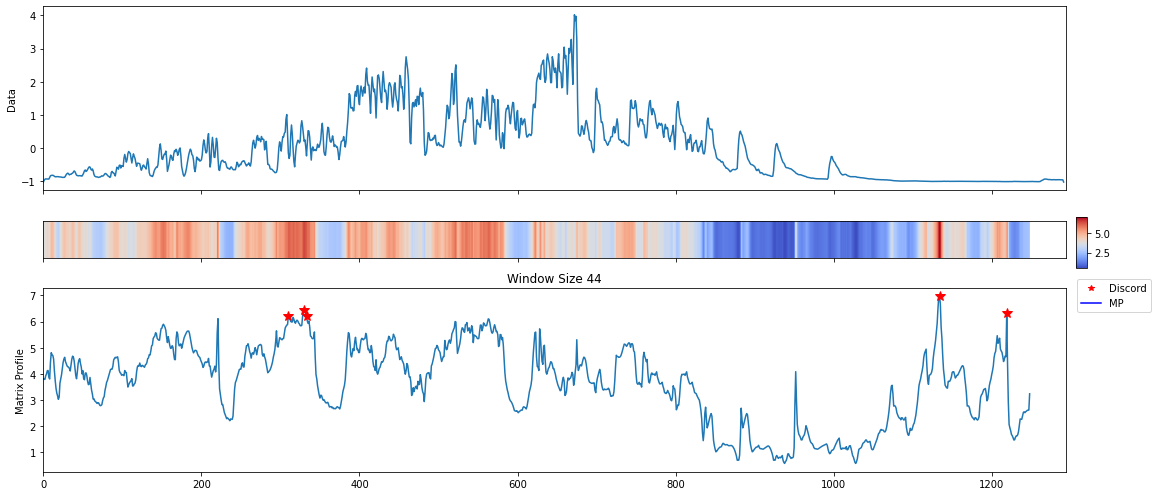

In [38]:
ts = ts_list2[1]
profile = mp.compute(ts, 44)
anoms = mp.discover.discords(profile, k=5, exclusion_zone=3)
figures = mp.visualize(anoms)

In [89]:
colors = ['r', 'g', 'k', 'b', 'y', 'lime', 'm', 'darkorange', 'tab:brown']

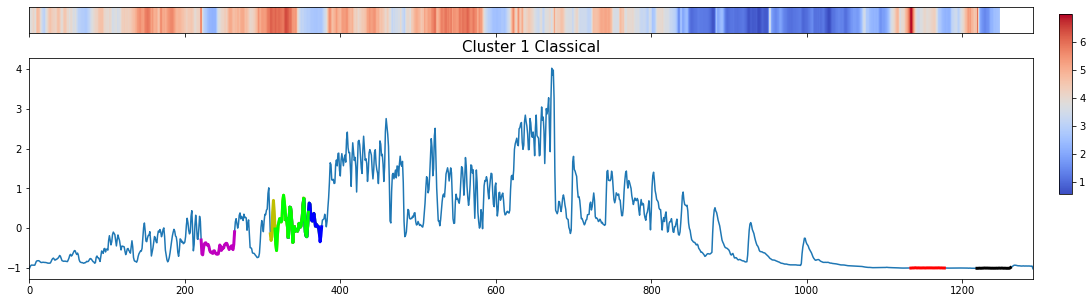

In [127]:
ts = ts_list2[1]
profile = mp.compute(ts, 44)
profile = mp.discover.discords(profile, k=7, exclusion_zone=3)
# We have to adjust the matrix profile to match the dimensions of the original
# time series
mp_adjusted = np.append(profile['mp'], np.zeros(profile['w'] - 1) + np.nan)

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(18, 5), gridspec_kw={'height_ratios': [3, 25]})
pos = axes[0].imshow([mp_adjusted,], aspect='auto', cmap='coolwarm')
axes[0].set_yticks([])

#Plot the Matrix Profile
axes[1].plot(np.arange(len(profile['data']['ts'])), profile['data']['ts'])
axes[1].set_title('Cluster 1 Classical', size=15)
i=0
for discord in profile['discords']:
    x = np.arange(discord, discord + profile['w'])
    y = profile['data']['ts'][discord:discord + profile['w']]

    axes[1].plot(x, y, linewidth=3,c=colors[i])
    i=i+1
    
cbar_ax = fig.add_axes([0.92, 0.36, 0.01, 0.5])
fig.colorbar(pos, orientation='vertical', cax=cbar_ax, use_gridspec=True)

plt.savefig('anomalies_classical.pdf', bbox_inches='tight')
plt.show()

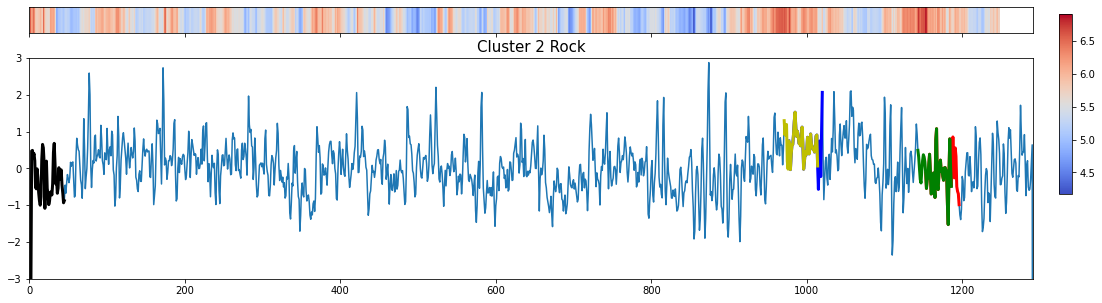

In [131]:
ts = ts_list1[2]
profile = mp.compute(ts, 44)
profile = mp.discover.discords(profile, k=5, exclusion_zone=3)
# We have to adjust the matrix profile to match the dimensions of the original
# time series
mp_adjusted = np.append(profile['mp'], np.zeros(profile['w'] - 1) + np.nan)

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(18, 5), gridspec_kw={'height_ratios': [3, 25]})
pos = axes[0].imshow([mp_adjusted,], aspect='auto', cmap='coolwarm')
axes[0].set_yticks([])

#Plot the Matrix Profile
axes[1].plot(np.arange(len(profile['data']['ts'])), profile['data']['ts'])
axes[1].set_title('Cluster 2 Rock', size=15)
axes[1].set_ylim(-3,3)
i=0
for discord in profile['discords']:
    x = np.arange(discord, discord + profile['w'])
    y = profile['data']['ts'][discord:discord + profile['w']]

    axes[1].plot(x, y, linewidth=3,c=colors[i])
    i=i+1
    
cbar_ax = fig.add_axes([0.92, 0.36, 0.01, 0.5])
fig.colorbar(pos, orientation='vertical', cax=cbar_ax, use_gridspec=True)

plt.savefig('anomalies_rock.pdf', bbox_inches='tight')
plt.show()